# Libraries

In [17]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from colabgymrender.recorder import Recorder

# CartPole

## NeuralNetwork

In [21]:
class NeuronNetwork(nn.Module):
    def __init__(self, env):
        super(NeuronNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            #nn.ReLU(),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

## DQN

In [22]:
class DQN():
    def __init__(self, env, max_epsilon, min_epsilon, max_num_steps, \
                 epsilon_decay_intervals, gamma, alpha, \
                 memory_size, min_replay_size, batch_size, \
                 target_update_frequency):
        # Environment
        self.env = env

        # Hyperparameters
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.max_num_steps = max_num_steps
        self.epsilon_decay_intervals = epsilon_decay_intervals
        self.gamma = gamma # discount value
        self.alpha = alpha # learning rate

        # Memory parameters
        self.memory_size = memory_size
        self.min_replay_size = min_replay_size
        self.batch_size = batch_size
        self.memory = None

        self.target_update_frequency = target_update_frequency # target network update frequency

        # Network
        self.q_net = NeuronNetwork(self.env).to(device)
        self.target_net = NeuronNetwork(self.env).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.alpha)

    def choose_action(self, epsilon, state):
        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.q_net.choose_action(state)
        return action

    def get_batch_from_memory(self, memory):
        experiences = random.sample(memory, self.batch_size)

        # Take batches from experiences
        states = np.array([ex[0] for ex in experiences])
        actions = np.array([ex[1] for ex in experiences])
        rewards = np.array([ex[2] for ex in experiences])
        dones = np.array([ex[3] for ex in experiences])
        next_states = np.array([ex[4] for ex in experiences])

        # Convert to tensor
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        dones = torch.tensor(dones, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

        return states, actions, rewards, dones, next_states

    def fill_memory(self):
        # Init memory with maxlen
        self.memory = deque(maxlen=self.memory_size)
        state = self.env.reset()

        # Loop min_replay_size times and append experience to memory
        for _ in range(self.min_replay_size):
            # Randomly taking action
            action = self.env.action_space.sample()

            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)
            self.memory.append(experience)

            state = next_state
            if done:
                self.env.reset()

        return self.memory

    def training(self):
        # Fill memory
        self.fill_memory()
        reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

        reward_per_episode = 0.0
        state = self.env.reset()
        all_rewards = []

        for step in range(self.max_num_steps):
            # Computer epsilon
            epsilon = np.interp(step, [0, self.epsilon_decay_intervals], [self.max_epsilon, self.min_epsilon])

            # Choose action to take
            action = self.choose_action(epsilon, state)

            # Take action and add experience to memory
            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)
            self.memory.append(experience)
            reward_per_episode += reward

            state = next_state

            # If done, 1 episode is done
            if done:
                state = self.env.reset()
                reward_buffer.append(reward_per_episode)
                all_rewards.append((step, reward_per_episode))
                reward_per_episode = 0.0

            # Get batch from memory for training
            states, actions, rewards, dones, next_states = self.get_batch_from_memory(self.memory)

            # Compute targets using the formulation sample = r + gamma * max q(s',a')
            target_q_values = self.target_net(next_states)
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rewards + self.gamma * (1 - dones) * max_target_q_values

            # Compute loss
            q_values = self.q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)
            loss = torch.nn.functional.mse_loss(action_q_values, targets)

            # Gradient descent for q-network
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update target network
            if (step + 1) % self.target_update_frequency == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())

            # Print training results
            if (step+1) % 1000 == 0:
                average_reward = np.mean(reward_buffer)
                print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')
        return all_rewards

## Run

In [23]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount value
alpha = 5e-4 # learning rate

# Memory
memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [24]:
env = gym.make('CartPole-v1')
model_cartpole = DQN(env, max_epsilon, min_epsilon, max_num_steps, \
                 epsilon_decay_intervals, gamma, alpha, \
                 memory_size, min_replay_size, batch_size, \
                 target_update_frequency)
all_rewards = model_cartpole.training()

Episode: 47 Step: 1000 Average reward: 21.02127659574468
Episode: 100 Step: 2000 Average reward: 19.92
Episode: 150 Step: 3000 Average reward: 19.45
Episode: 185 Step: 4000 Average reward: 22.02
Episode: 207 Step: 5000 Average reward: 28.77
Episode: 226 Step: 6000 Average reward: 34.78
Episode: 238 Step: 7000 Average reward: 42.48
Episode: 249 Step: 8000 Average reward: 50.0
Episode: 256 Step: 9000 Average reward: 58.1
Episode: 260 Step: 10000 Average reward: 66.72
Episode: 264 Step: 11000 Average reward: 76.14
Episode: 268 Step: 12000 Average reward: 83.3
Episode: 270 Step: 13000 Average reward: 90.56
Episode: 273 Step: 14000 Average reward: 100.44
Episode: 278 Step: 15000 Average reward: 111.72
Episode: 280 Step: 16000 Average reward: 121.16
Episode: 282 Step: 17000 Average reward: 127.4
Episode: 285 Step: 18000 Average reward: 137.87
Episode: 287 Step: 19000 Average reward: 147.05
Episode: 291 Step: 20000 Average reward: 156.95
Episode: 294 Step: 21000 Average reward: 166.39
Episode

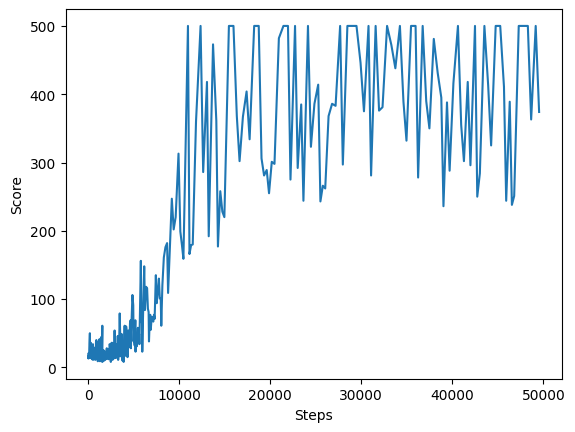

In [25]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [26]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
model.q_net.eval()

with torch.no_grad():
    while not done:
        action = model.q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

369.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# MountainCar

## Neural Network

In [89]:
class NeuronNetwork(nn.Module):
    def __init__(self, env):
        super(NeuronNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n),

        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

## DQN

In [90]:
class DQN():
    def __init__(self, env, max_epsilon, min_epsilon, max_num_steps, \
                 epsilon_decay_intervals, gamma, alpha, \
                 memory_size, min_replay_size, batch_size, \
                 target_update_frequency):
        # Environment
        self.env = env

        # Hyperparameters
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.max_num_steps = max_num_steps
        self.epsilon_decay_intervals = epsilon_decay_intervals
        self.gamma = gamma # discount value
        self.alpha = alpha # learning rate

        # Memory parameters
        self.memory_size = memory_size
        self.min_replay_size = min_replay_size
        self.batch_size = batch_size
        self.memory = None

        self.target_update_frequency = target_update_frequency # target network update frequency

        # Network
        self.q_net = NeuronNetwork(self.env).to(device)
        self.target_net = NeuronNetwork(self.env).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.alpha)

    def choose_action(self, epsilon, state):
        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.q_net.choose_action(state)
        return action

    def get_batch_from_memory(self, memory):
        experiences = random.sample(memory, self.batch_size)

        # Take batches from experiences
        states = np.array([ex[0] for ex in experiences])
        actions = np.array([ex[1] for ex in experiences])
        rewards = np.array([ex[2] for ex in experiences])
        dones = np.array([ex[3] for ex in experiences])
        next_states = np.array([ex[4] for ex in experiences])

        # Convert to tensor
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        dones = torch.tensor(dones, dtype=torch.float32).to(device).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)

        return states, actions, rewards, dones, next_states

    def fill_memory(self):
        # Init memory with maxlen
        self.memory = deque(maxlen=self.memory_size)
        state = self.env.reset()

        # Loop min_replay_size times and append experience to memory
        for _ in range(self.min_replay_size):
            # Randomly taking action
            action = self.env.action_space.sample()

            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)
            self.memory.append(experience)

            state = next_state
            if done:
                self.env.reset()

        return self.memory

    def training(self):
        # Fill memory
        self.fill_memory()
        reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

        reward_per_episode = 0.0
        state = self.env.reset()
        all_rewards = []

        for step in range(self.max_num_steps):
            # Computer epsilon
            epsilon = np.interp(step, [0, self.epsilon_decay_intervals], [self.max_epsilon, self.min_epsilon])

            # Choose action to take
            action = self.choose_action(epsilon, state)

            # Take action and add experience to memory
            next_state, reward, done, info = self.env.step(action)
            experience = (state, action, reward, done, next_state)
            self.memory.append(experience)
            reward_per_episode += reward

            state = next_state

            # If done, 1 episode is done
            if done:
                state = self.env.reset()
                reward_buffer.append(reward_per_episode)
                all_rewards.append((step, reward_per_episode))
                reward_per_episode = 0.0

            # Get batch from memory for training
            states, actions, rewards, dones, next_states = self.get_batch_from_memory(self.memory)

            # Compute targets using the formulation sample = r + gamma * max q(s',a')
            target_q_values = self.target_net(next_states)
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rewards + self.gamma * (1 - dones) * max_target_q_values

            # Compute loss
            q_values = self.q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)
            loss = torch.nn.functional.mse_loss(action_q_values, targets)

            # Gradient descent for q-network
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update target network
            if (step + 1) % self.target_update_frequency == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())

            # Print training results
            if (step+1) % 1000 == 0:
                average_reward = np.mean(reward_buffer)
                print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')
        return all_rewards

## Run

In [91]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 200000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 1e-3 # learning rate

# Memory
memory_size = 100000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [92]:
env = gym.make('MountainCar-v0')
model_mountaincar = DQN(env, max_epsilon, min_epsilon, max_num_steps, \
                 epsilon_decay_intervals, gamma, alpha, \
                 memory_size, min_replay_size, batch_size, \
                 target_update_frequency)
all_rewards = model_mountaincar.training()

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -200.0
Episode: 85 Step: 17000 Average reward: -200.0
Episode: 90 Step: 18000 Average reward: -200.0
Episode: 95 Step: 19000 Average reward: -200.0
Episode: 100 Step: 20000 Average reward: -200.0
Episode: 105 Step: 21000 Average reward: -200.0
Episode: 110 Step: 22

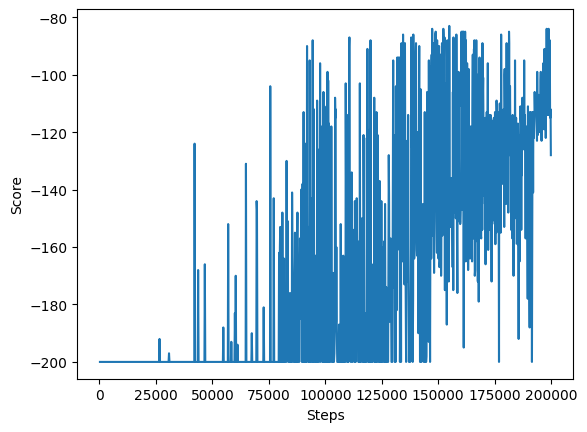

In [93]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [94]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
model_mountaincar.q_net.eval()

with torch.no_grad():
    while not done:
        action = model_mountaincar.q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

-110.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Adjust for MountainCar-v0

* Change architecture of the neural network to
        network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n),
        )


* Change hyperparameters
    * max_num_steps = 200000 (increase max_num_steps)
    * alpha = 1e-3 ( increase learning rate)
    * memory_size = 100000 (increase memory size)